In [32]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
print(df.head())
print(df.tail())

    Timestamp  Open  High   Low  Close  Volume_(BTC)  Volume_(Currency)  \
0  1325317920  4.39  4.39  4.39   4.39      0.455581                2.0   
1  1325317980   NaN   NaN   NaN    NaN           NaN                NaN   
2  1325318040   NaN   NaN   NaN    NaN           NaN                NaN   
3  1325318100   NaN   NaN   NaN    NaN           NaN                NaN   
4  1325318160   NaN   NaN   NaN    NaN           NaN                NaN   

   Weighted_Price  
0            4.39  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
          Timestamp      Open      High       Low     Close  Volume_(BTC)  \
4857372  1617148560  58714.31  58714.31  58686.00  58686.00      1.384487   
4857373  1617148620  58683.97  58693.43  58683.97  58685.81      7.294848   
4857374  1617148680  58693.43  58723.84  58693.43  58723.84      1.705682   
4857375  1617148740  58742.18  58770.38  58742.18  58760.59      0.720415   
4857376  1617148800  58767.75  58778.18  587

In [8]:
# Unix-time to 
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()
print(df_month.tail())

                    Open          High           Low         Close  \
Timestamp                                                            
2020-11-30  16530.188884  16540.060546  16519.995766  16530.432867   
2020-12-31  21810.891586  21825.256165  21796.032856  21811.295270   
2021-01-31  34553.473084  34593.508742  34511.853676  34553.599446   
2021-02-28  46076.500756  46116.985465  46035.188338  46077.063198   
2021-03-31  54639.891296  54674.763269  54605.192891  54641.412965   

            Volume_(BTC)  Volume_(Currency)  Weighted_Price  
Timestamp                                                    
2020-11-30      6.684712      110828.794944    16530.401656  
2020-12-31      5.740538      129193.865128    21810.922846  
2021-01-31     10.249651      352391.120149    34551.684656  
2021-02-28      5.964004      274306.654409    46074.940877  
2021-03-31      3.527373      192206.908427    54638.339142  


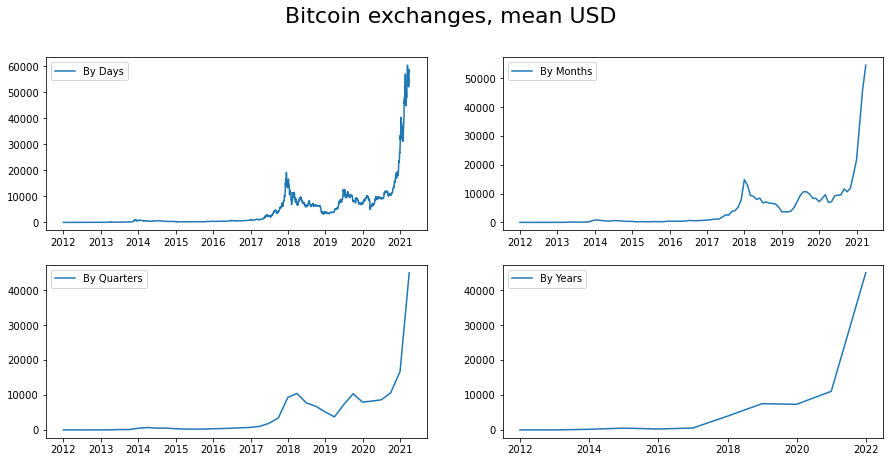

In [9]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

Dickey–Fuller test: p=0.998863


<Figure size 1080x504 with 0 Axes>

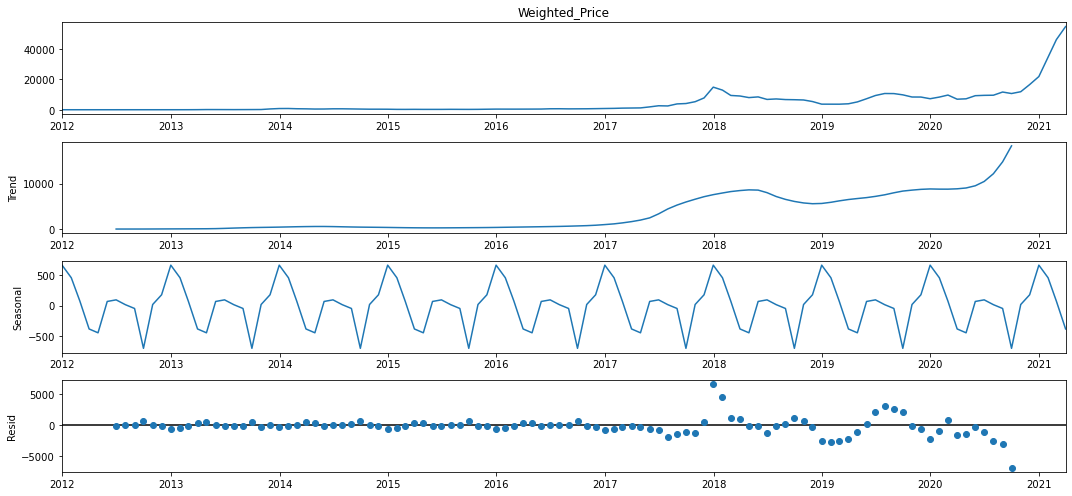

In [10]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

In [11]:
# Box-Cox Transformations
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

Dickey–Fuller test: p=0.998863


In [12]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.444282


Dickey–Fuller test: p=0.000024


<Figure size 1080x504 with 0 Axes>

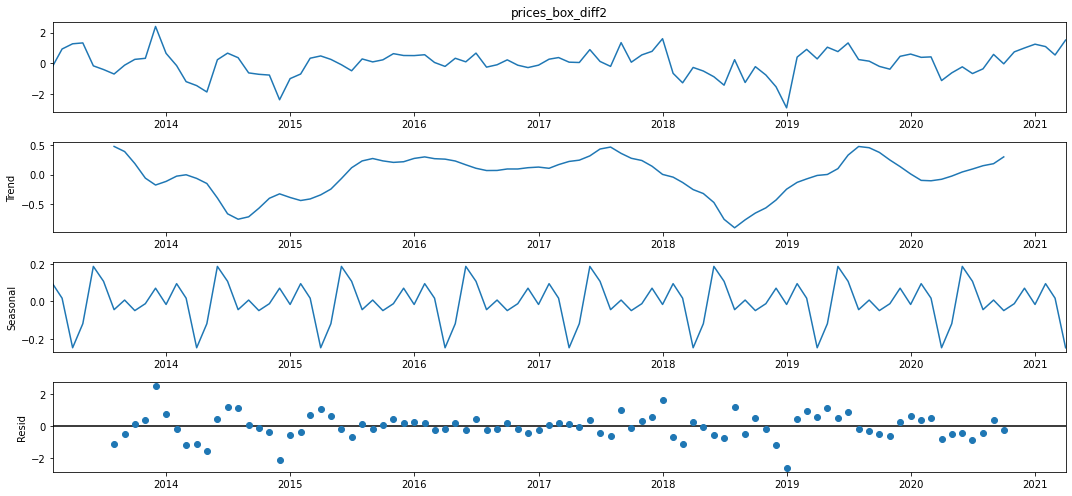

In [13]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

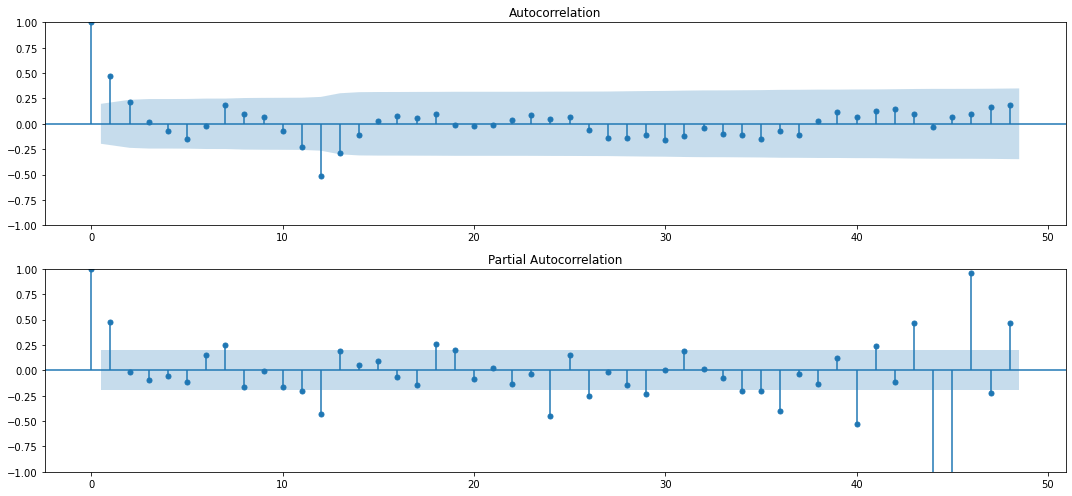

In [14]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [17]:
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [18]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  173.616541
21  (1, 0, 1, 1)  174.766385
25  (1, 1, 0, 1)  175.547141
37  (2, 0, 0, 1)  175.554970
7   (0, 1, 0, 1)  175.589200
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                  112
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -83.808
Date:                              Fri, 04 Nov 2022   AIC                            173.617
Time:                                      20:27:36   BIC                            181.402
Sample:                                  12-31-2011   HQIC                           176.767
                                       - 03-31-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

Dickey–Fuller test:: p=0.000000


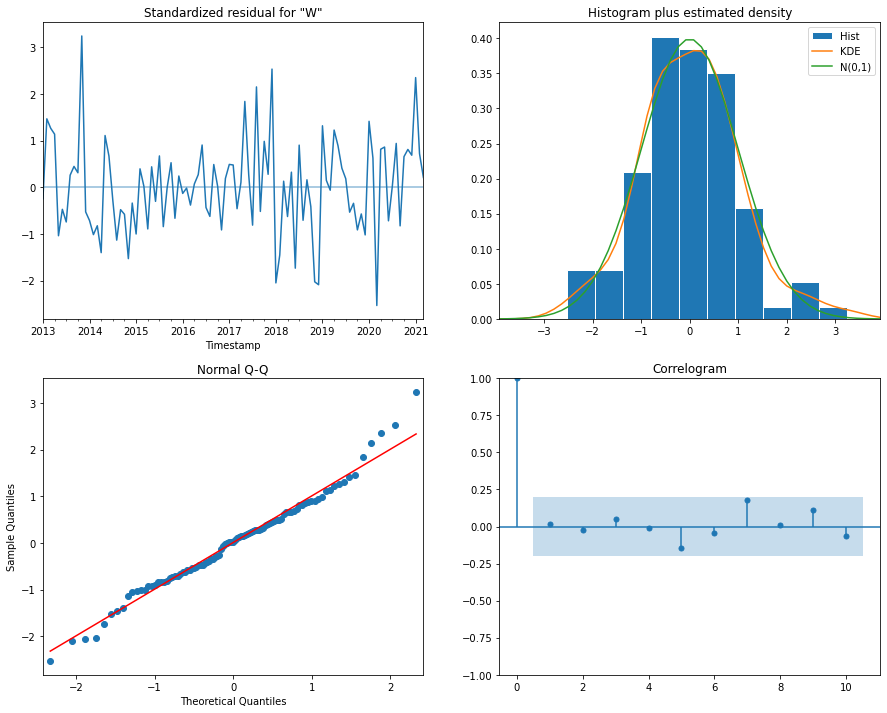

In [31]:
# STL-decomposition
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [23]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

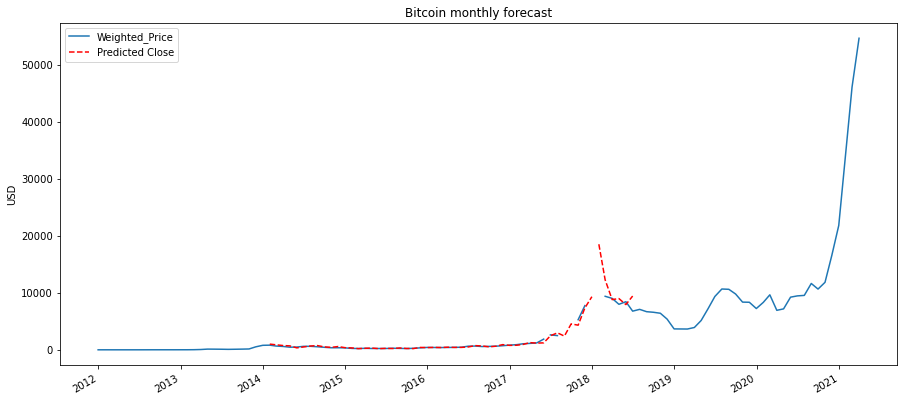

In [30]:
# Prediction
btc_pred = df_month[['Weighted_Price']]
date_list = [datetime(2017, 6, 30), datetime(2017, 7, 31), datetime(2017, 8, 31), datetime(2017, 9, 30), 
             datetime(2017, 10, 31), datetime(2017, 11, 30), datetime(2017, 12, 31), datetime(2018, 1, 31),
             datetime(2018, 1, 28)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
btc_pred = pd.concat([btc_pred, future])
btc_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2014,1,31),end=datetime(2018,6,30)),lmbda)
plt.figure(figsize=(15,7))
btc_pred.Weighted_Price.plot()
btc_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()